In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras import layers, models
from keras.applications import InceptionV3

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.WARNING)


In [2]:
base_path = "dataset"
dogs_directory = "dog"
cats_directory = "cat"

In [3]:
num_skipped = 0
for folder_name in ( dogs_directory , cats_directory):
    folder_path = os.path.join(base_path, folder_name)
    for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = b"JFIF" in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


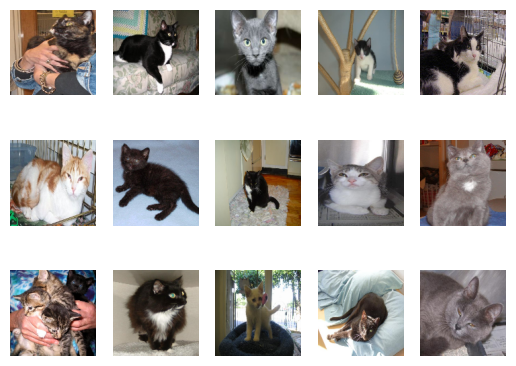

In [4]:
def display_images(path): 
    image_list = os.listdir(path)[:15]
    for i, image_path in enumerate(image_list):
        image = cv2.imread(os.path.join(path, image_path))
        image = cv2.resize(image, (128, 128))  
        plt.subplot(3, 5, i + 1) 
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()
    

display_images(os.path.join(base_path, cats_directory))




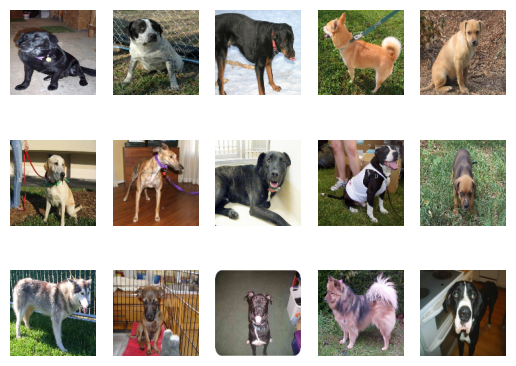

In [5]:
display_images(os.path.join(base_path, dogs_directory))


In [6]:
def load_and_preprocess_data(dataset_path):
    images = []
    labels = []

    for label, category in enumerate([dogs_directory , cats_directory]):
        category_path = os.path.join(base_path, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg"):
                image_path = os.path.join(category_path, filename)
                image = cv2.imread(image_path)

                if image is not None and not image.size:
                    print(f"Invalid image size: {image_path}")
                    continue

                image = cv2.resize(image, (128, 128))  
                images.append(image)
                labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=2) 

    return images, labels

images, labels = load_and_preprocess_data(base_path)

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


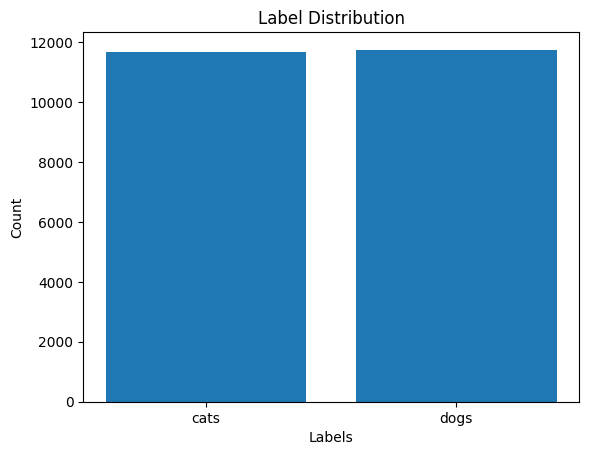

In [7]:
cats = np.sum(labels[:, 0] == 1)
dogs = np.sum(labels[:, 0] == 0)
plt.bar(['cats' , 'dogs' ] , [cats,dogs])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
def plot_graphs(train_loss , validation_loss , train_accuracy , validation_accuracy ):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax1 = axes[0]
    ax1.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    ax1.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')

    ax1.set_title(f'Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2 = axes[1]
    ax2.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
    ax2.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')

    ax2.set_title(f'Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()


    plt.tight_layout()
    plt.show()

In [17]:

def plot_confusion_matrix(model, X_test , y_test  ):
    predicted_values = model.predict(X_test)
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_values, axis=1))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=[ 1, 2 ], yticklabels=[ 1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [11]:
def initilize_model ():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = initilize_model ()


In [12]:

history = model.fit(X_train, y_train,epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
586/586 [==============================] - 136s 232ms/step - loss: 0.7966 - accuracy: 0.6603 - val_loss: 0.7518 - val_accuracy: 0.5812
Epoch 2/5
586/586 [==============================] - 287s 490ms/step - loss: 0.5434 - accuracy: 0.7345 - val_loss: 0.4802 - val_accuracy: 0.7749
Epoch 3/5
586/586 [==============================] - 245s 418ms/step - loss: 0.4852 - accuracy: 0.7664 - val_loss: 0.6167 - val_accuracy: 0.6448
Epoch 4/5
586/586 [==============================] - 186s 317ms/step - loss: 0.4276 - accuracy: 0.8038 - val_loss: 0.9144 - val_accuracy: 0.6602
Epoch 5/5
586/586 [==============================] - 145s 247ms/step - loss: 0.3758 - accuracy: 0.8336 - val_loss: 0.6078 - val_accuracy: 0.7811


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                        

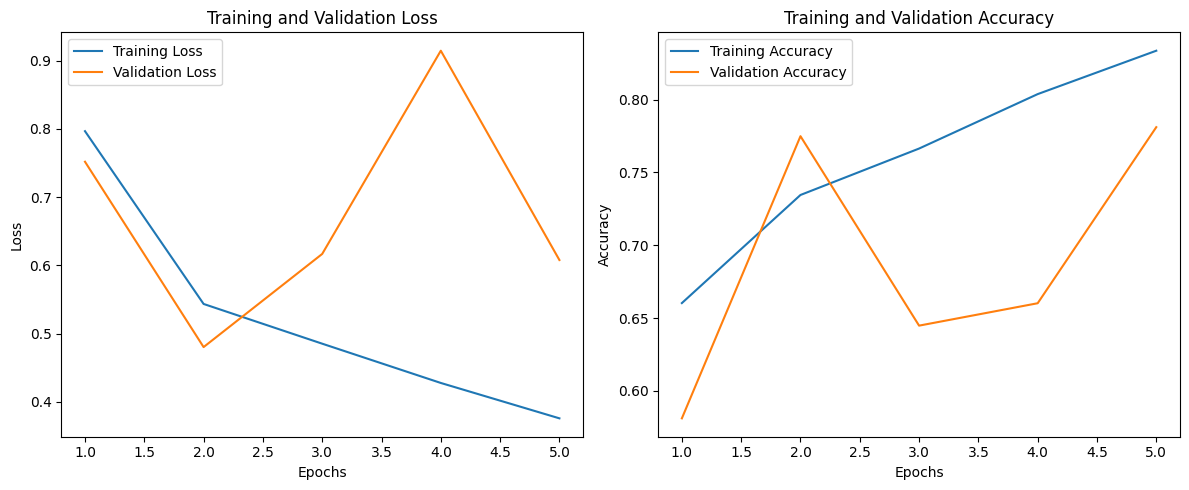

In [14]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
plot_graphs(train_loss , validation_loss , train_accuracy , validation_accuracy )

In [15]:
tensorflow_model = model

147/147 [==============================] - 7s 45ms/step


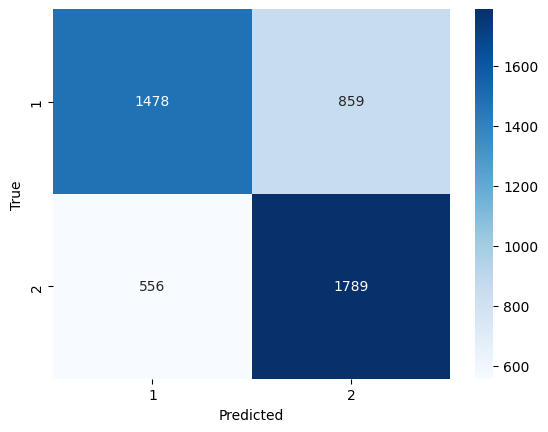

In [18]:
plot_confusion_matrix(model, X_test , y_test  )

In [19]:

def initialize_inceptionv3_model(input_shape=(128, 128, 3), num_classes=2):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False 
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='sigmoid'))

    for layer in base_model.layers[-5:]:
        layer.trainable = True


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = initialize_inceptionv3_model()



In [20]:

history = model.fit(X_train, y_train,epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
586/586 [==============================] - 165s 280ms/step - loss: 0.6493 - accuracy: 0.6410 - val_loss: 0.6440 - val_accuracy: 0.6301
Epoch 2/5
586/586 [==============================] - 148s 252ms/step - loss: 0.6210 - accuracy: 0.6569 - val_loss: 0.6141 - val_accuracy: 0.6732
Epoch 3/5
586/586 [==============================] - 156s 266ms/step - loss: 0.6154 - accuracy: 0.6605 - val_loss: 0.6150 - val_accuracy: 0.6636
Epoch 4/5
586/586 [==============================] - 153s 261ms/step - loss: 0.6097 - accuracy: 0.6656 - val_loss: 0.6278 - val_accuracy: 0.6536
Epoch 5/5
586/586 [==============================] - 153s 262ms/step - loss: 0.6058 - accuracy: 0.6683 - val_loss: 0.6194 - val_accuracy: 0.6713


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_97 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 22065826 (84.17 MB)
Trainable params: 26

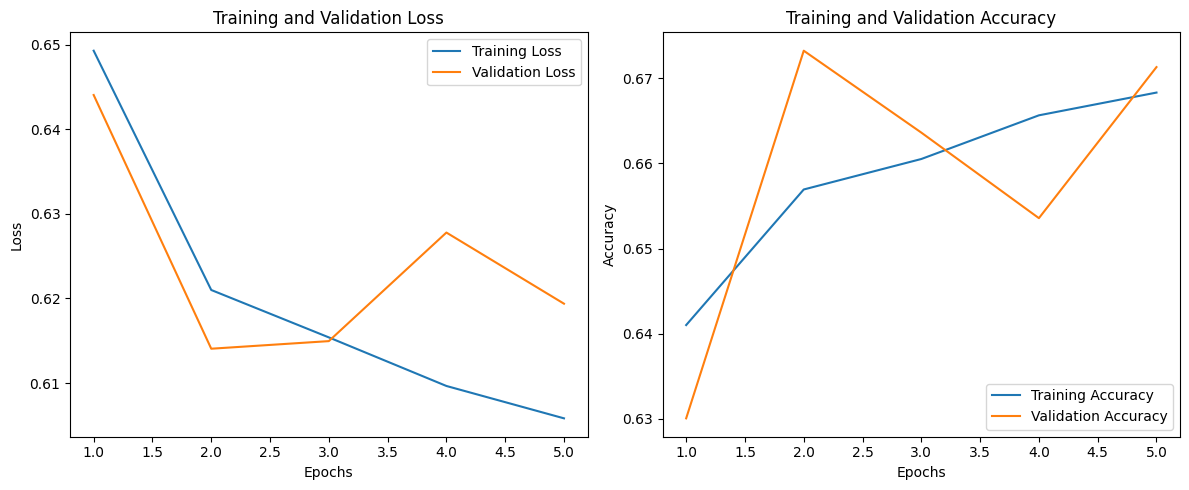

In [22]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
plot_graphs(train_loss , validation_loss , train_accuracy , validation_accuracy )

147/147 [==============================] - 31s 211ms/step


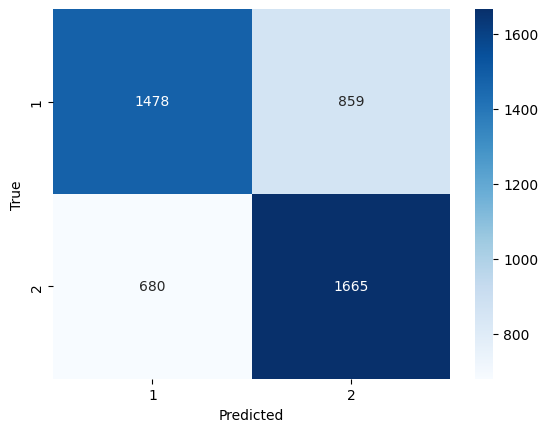

In [23]:
plot_confusion_matrix(model, X_test , y_test  )